# Equity Premium Linear Forecast

This notebook replicates the experiment of Rapach, D. E., Strauss, J. K., & Zhou, G. (2010). Out-of-Sample Equity Premium Prediction: Combination Forecasts and Links to the Real Economy. The Review of Financial Studies, 23(2), 821–862. https://doi.org/10.1093/rfs/hhp063

The first section predicts the equity premium using each individual economic variable. The second section combines all of the economic variables to predict the equity premium.

This notebook refers to the following three papers:

1. Rapach, D. E., Strauss, J. K., & Zhou, G. (2010). Out-of-Sample Equity Premium Prediction: Combination Forecasts and Links to the Real Economy. The Review of Financial Studies, 23(2), 821–862. https://doi.org/10.1093/rfs/hhp063

2. Welch, I., & Goyal, A. (2008). A Comprehensive Look at The Empirical Performance of Equity Premium Prediction. Review of Financial Studies, 21(4), 1455–1508. https://doi.org/10.1093/rfs/hhm014

3. Lu, Y. (Jacques), & Han, Y. (2022). Macroeconomic Extrapolation, Machine Learning, and Equity Risk Premium Forecast (SSRN Scholarly Paper No. 4102419). https://doi.org/10.2139/ssrn.4102419

The content:

   [1. Individual prediction model](##1.-individual-prediction-model)
   
   [2. Combining prediction model](##2.-combining-prediction-model)

   [3. Historical Average](##3.-historical-average)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../module')

from data_handler import get_econ_predictors
from data_handler import get_monthly_date_format
from data_handler import get_quarterly_date_format
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

## 1. Individual prediction model

For each individual economic variable, we consider the same prediction model.

$$
\begin{equation}
r_{t+1}=\alpha_i+\beta_i x_{i, t}+\varepsilon_{t+1}
\end{equation}
$$

For each individual prediction model, we utilize the expanding window. According to (Rapach 2010), we consider three out-of-sample (OOS) peridos, i.e. 1965/01 - 2005/04, 1976/1 – 2005/4, 2000/1 – 2005/4. We use the first period as example, then replicate the same process on other periods. No matter which OOS period, we assume the same in-sample starting date as 1947/1.

In [2]:
START_DATE_TOTAL = '1947-01'
START_DATE_OOS_X = '1954-12'
START_DATE_OOS_Y = '1955-01'
END_DATE = '2005-04'

econ_predictors = get_econ_predictors(START_DATE=START_DATE_TOTAL, END_DATE=END_DATE, data_freq='monthly')
equity_premium = econ_predictors.pop('Equity Premium')
econ_predictors = econ_predictors[:-1] # drop the last element, because there's no OOS prediction true value for the last date
equity_premium = equity_premium[1:] # shift the label 1 day backwards to make it prediction problem

econ_predictors_oos = econ_predictors[START_DATE_OOS_X:END_DATE]
equity_premium_oos = equity_premium[START_DATE_OOS_Y:END_DATE]

oos_size = len(equity_premium_oos)

In [3]:
econ_predictors

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,Term Spread,Default Yield Spread,Default Return Spread,Inflation
1947-06,-2.996390,-2.993757,-2.357310,-0.639080,0.006811,0.741117,0.026473,0.0038,0.0216,0.000587,0.0178,0.0066,0.003818,0.004566
1947-09,-2.951079,-2.957675,-2.277102,-0.673977,0.004187,0.740323,0.024059,0.0080,0.0213,0.009987,0.0133,0.0062,-0.028135,0.045455
1947-12,-2.902206,-2.889710,-2.251619,-0.650588,0.002453,0.725326,0.025922,0.0095,0.0243,-0.039832,0.0148,0.0066,0.022582,0.017391
1948-03,-2.875888,-2.890372,-2.176876,-0.699012,0.004887,0.841422,0.027187,0.0100,0.0241,0.010032,0.0141,0.0070,0.007850,0.000000
1948-06,-2.980320,-2.875888,-2.197225,-0.783095,0.002912,0.786974,0.023894,0.0100,0.0238,0.010107,0.0138,0.0058,-0.013842,0.029915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-12,-4.158236,-4.048109,-3.127343,-1.030892,0.003221,0.218740,0.006946,0.0090,0.0515,-0.017453,0.0425,0.0098,0.015937,-0.004860
2004-03,-4.134909,-4.122139,-3.075370,-1.059540,0.003571,0.281731,0.012282,0.0094,0.0474,0.056824,0.0380,0.0078,-0.007757,0.016820
2004-06,-4.116251,-4.103344,-3.011493,-1.104758,0.002979,0.279632,0.014491,0.0127,0.0532,-0.052270,0.0405,0.0077,0.000890,0.012273
2004-09,-4.063252,-4.086539,-2.959763,-1.103488,0.002926,0.289485,0.009132,0.0165,0.0488,0.065746,0.0323,0.0081,0.003573,0.001054


In [4]:
def get_linear_prediction(X_train:np.array, y_train:np.array, X_test:np.array) -> np.array:
    """
    Fit a linear regression model on the training data and get predictions on the test data

    Parameters
    ----------
    X_train: np.array
        Training data
    y_train: np.array
        Training label
    X_test: np.array
        Test data
    
    Returns
    -------
    prediction: np.array
        Prediction on the test data
    """
    model = LinearRegression().fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
    prediction = model.predict(X_test.reshape(-1,1))

    return prediction


In [5]:
get_linear_prediction(X_train=econ_predictors.iloc[0:214,0].values, 
                      y_train=equity_premium.iloc[0:214].values, 
                      X_test=econ_predictors.iloc[215,0])

array([[-0.0025964]])

In [7]:
def get_ts_predictions(X:np.ndarray, y:np.ndarray, X_test_size:int) -> np.ndarray:
    """
    Build linear models on training data in expanding window way.
    Get a series of predictions from the test data using the fit models.

    Parameters
    ----------
    X : np.array
        Whole sample of feature data.
        shape = (n_samples, 1)
    y : np.array
        Whole sample of labels.
        shape = (n_samples, 1)
    X_test_size : int
        Size of the test sample.

    Returns
    -------
    np.array
        Time series predictions.
        shape = (n_samples, 1)
    """

    expanding_window_idx_generator = TimeSeriesSplit(n_splits = X_test_size, test_size=1)
    prediction = [get_linear_prediction(X_train=X[train_index], 
                                        y_train=y[train_index], 
                                        X_test=X[test_index])
                                        for _, (train_index, test_index) in enumerate(expanding_window_idx_generator.split(econ_predictors))]
    prediction = np.array(prediction).reshape(-1)
    return prediction


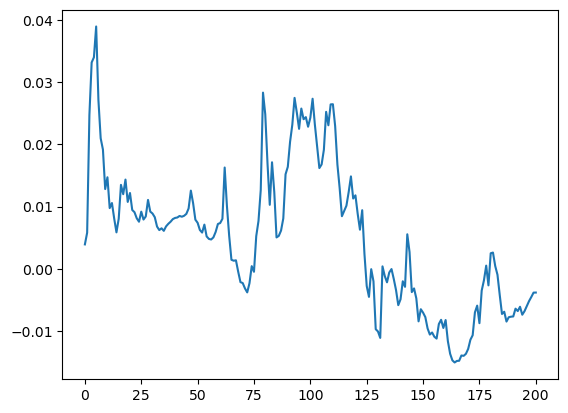

In [8]:
pred = get_ts_predictions(X=econ_predictors['Dividend Price Ratio'].values, 
                          y=equity_premium.values,
                          X_test_size=len(econ_predictors_oos))
plt.plot(pred)

repeat the time series predictions of the equity premium over each individual economic variable

In [9]:
prediction_dict = {predictor: get_ts_predictions(X=econ_predictors[predictor].values, 
                                                 y=equity_premium.values, 
                                                 X_test_size=oos_size)
                   for predictor in econ_predictors.columns}

In [10]:
prediction_df = pd.DataFrame(prediction_dict)
prediction_df.index = equity_premium_oos.index
prediction_df

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,Term Spread,Default Yield Spread,Default Return Spread,Inflation
1955-03,0.003910,0.005255,0.024421,0.030791,0.028041,0.013499,0.028236,0.032657,0.025737,0.027194,0.047954,0.017508,0.030906,0.034731
1955-06,0.005800,-0.001467,0.023393,0.027410,0.025241,0.013855,0.028376,0.027746,0.023766,0.006278,0.046643,0.003124,0.043181,0.031225
1955-09,0.024728,0.021114,0.033828,0.026218,0.028409,0.034669,0.029418,0.026321,0.032727,0.028120,0.047939,0.016550,0.030222,0.034546
1955-12,0.033169,0.026982,0.036673,0.025958,0.034028,0.041765,0.030601,0.006219,0.036029,0.028248,0.013685,0.021166,0.032411,0.029675
1956-03,0.034000,0.028546,0.036456,0.024726,0.031939,0.041608,0.030444,-0.003271,0.035713,0.034825,-0.012870,0.023197,0.026485,0.038585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-03,-0.006007,-0.005336,0.002780,0.002059,0.007702,0.006590,0.015578,0.025977,0.012815,0.002590,0.034002,0.010444,0.015647,0.025124
2004-06,-0.005212,-0.006713,0.003688,0.001564,0.008153,0.007214,0.013007,0.025628,0.013790,0.019375,0.029647,0.008993,0.006899,0.002348
2004-09,-0.004551,-0.005986,0.004767,0.000734,0.007426,0.007233,0.011945,0.024136,0.012378,-0.005195,0.031404,0.008928,0.010093,0.007125
2004-12,-0.003847,-0.005966,0.005391,0.000026,0.007198,0.006962,0.014295,0.022123,0.013238,0.021354,0.023692,0.009051,0.010919,0.018661


## 2. Combining prediction model

We consider four different combination methods for equity premium prediction:

1. Mean
2. Median
3. Trimmed Mean
4. DMSPE-based (discounted mean squared prediction error)

### 2.1 Mean combination

In [191]:
mean = prediction_df.values.mean(axis=1)

### 2.2 Median combination

In [195]:
median = np.median(prediction_df.values, axis=1)

## 2.3 Trimmed mean

In [138]:
prediction_copy = np.copy(prediction_df.values)
prediction_copy.sort(axis=1)
prediction_trimmed = prediction_copy[:,1:-1]
trimmed_mean = prediction_trimmed.mean(axis=1)
trimmed_mean

array([ 7.25460476e-03,  5.04303106e-03,  5.61821081e-03,  7.00658772e-03,
        6.34133775e-03,  6.86392868e-03,  6.76132900e-03,  9.02264028e-03,
        8.71977426e-03,  8.93647501e-03,  7.99433517e-03,  8.66065303e-03,
        8.33156324e-03,  7.10176591e-03,  7.64186715e-03,  9.37921519e-03,
        8.45425269e-03,  8.46825573e-03,  7.81754892e-03,  7.44026662e-03,
        7.46703351e-03,  6.79953126e-03,  6.21806751e-03,  5.74638854e-03,
        4.66682096e-03,  6.92728837e-03,  4.40965448e-03,  3.97379410e-03,
        3.28280423e-03,  6.00475451e-03,  4.91995056e-03,  5.62242052e-03,
        5.08206107e-03,  3.77990171e-03,  2.30666763e-03,  5.40135146e-03,
        1.57090452e-03,  3.47010085e-03,  5.84291432e-03,  6.18848169e-03,
        6.91603972e-03,  6.16114990e-03,  5.56394352e-03,  5.76157526e-03,
        5.25868725e-03,  5.62186042e-03,  6.51645181e-03,  6.51029517e-03,
        5.92963668e-03,  5.86667624e-03,  6.81641846e-03,  6.52334975e-03,
        6.27359518e-03,  

### 2.4 DMSPE-based combination

This DMSPE-based combination approach firstly computes the DMSPE (discount mean square prediction error)

\begin{equation}
\phi_{i, t}=\sum_{s=m}^{t-1} \theta^{t-1-s}\left(r_{s+1}-\hat{r}_{i, s+1}\right)^2
\end{equation}

Here $m$ is the time origin of hold out period in the OOS prediction. We adopt two different values for the discount factor, i.e. $\theta = 1\; or\; 0.9$. Then we define the weight for each individual prediction in the combination prediction.

\begin{equation}
\omega_{i, t}=\phi_{i, t}^{-1} / \sum_{j=1}^N \phi_{j, t}^{-1}
\end{equation}

In [186]:
true_values = equity_premium_oos.values.reshape(-1,1)
theta = 0.9
discount_power = np.arange(len(true_values), 0, -1) - 1
discounted_theta = np.power(theta, discount_power).reshape(-1,1)
squared_prediction_error = np.square(prediction_df.values - true_values)
phi = np.cumsum(squared_prediction_error * discounted_theta, axis=0)
weight = (1 / phi) / np.sum(1 / phi, axis=1, keepdims=True)
DMSPE_prediction = np.sum(weight * prediction_df.values, axis=1)

In [203]:
np.vstack([mean, median, trimmed_mean, DMSPE_prediction]).T

array([[0.00682075, 0.00849502, 0.0072546 , 0.01096064],
       [0.00451422, 0.00628023, 0.00504303, 0.0053148 ],
       [0.00563094, 0.00647924, 0.00561821, 0.00566639],
       ...,
       [0.00318322, 0.00350758, 0.00324664, 0.00322512],
       [0.0024646 , 0.0024294 , 0.00241964, 0.00249652],
       [0.00228405, 0.00249065, 0.00236896, 0.00227835]])

wrap up everything into a function

In [11]:
def get_combined_prediction(true_values: np.ndarray, prediction: np.ndarray, prediction_index: pd.core.indexes, holdout_size: int) -> pd.DataFrame:
    """
    This function retruns four combined predictions from each individual economic model
    
    Parameters
    ----------
    true_values : np.ndarray
    
    prediction : np.ndarray
    
    Returns
    -------
    np.ndarray
    """
    mean = prediction.mean(axis=1)

    median = np.median(prediction, axis=1)
    
    prediction_copy = np.copy(prediction)
    prediction_copy.sort(axis=1)
    prediction_trimmed = prediction_copy[:,1:-1]
    trimmed_mean = prediction_trimmed.mean(axis=1)

    theta_1 = 1
    theta_2 = 0.9
    discount_power = np.arange(len(true_values), 0, -1) - 1
    discounted_theta_1 = np.power(theta_1, discount_power).reshape(-1,1)
    discounted_theta_2 = np.power(theta_2, discount_power).reshape(-1,1)
    squared_prediction_error = np.square(prediction - true_values)
    phi_1 = np.cumsum(squared_prediction_error * discounted_theta_1, axis=0)
    phi_2 = np.cumsum(squared_prediction_error * discounted_theta_2, axis=0)
    weight_1 = (1 / phi_1) / np.sum(1 / phi_1, axis=1, keepdims=True)
    weight_2 = (1 / phi_2) / np.sum(1 / phi_2, axis=1, keepdims=True)
    DMSPE_prediction_1 = np.sum(weight_1 * prediction, axis=1)
    DMSPE_prediction_2 = np.sum(weight_2 * prediction, axis=1)

    prediction_mat = np.vstack([mean, median, trimmed_mean, DMSPE_prediction_1, DMSPE_prediction_2]).T
    prediction_df = pd.DataFrame(prediction_mat, columns=['Mean', 'Median', 'Trimmed mean', 'DMSPE theta 1', 'DMSPE theta 0.9'], index=prediction_index)
    prediction_df = prediction_df.iloc[holdout_size:, :]
    
    return prediction_df

In [12]:
combined_prediction = get_combined_prediction(true_values=equity_premium_oos.values.reshape(-1,1), 
                                            prediction=prediction_df.values,
                                            prediction_index=equity_premium_oos.index,
                                            holdout_size=10 * 12)
combined_prediction

,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9
1985-03,0.012366,0.011279,0.011745,0.012450,0.013012
1985-06,0.009260,0.007931,0.008277,0.009329,0.009895
1985-09,0.011427,0.006461,0.010062,0.011329,0.010727
1985-12,0.010605,0.008089,0.009480,0.010705,0.011304
1986-03,0.010077,0.006836,0.009234,0.010062,0.010641
...,...,...,...,...,...
2004-03,0.010712,0.009073,0.010164,0.010752,0.010725
2004-06,0.009170,0.007683,0.008787,0.009174,0.009215
2004-09,0.007888,0.007329,0.007085,0.007883,0.007831
2004-12,0.010221,0.009985,0.010448,0.010261,0.010343


## 3. Historical Average

\begin{equation}
\bar{r_{t+1}} = \frac{\sum_{i=1}^t r_i}{t}
\end{equation}

In [13]:
def get_benchmark_of_equity_premium_prediction(equity_premium:np.ndarray, 
                                               prediction_size:int, 
                                               holdout_size:int,
                                               prediction_index: pd.core.indexes) -> pd.DataFrame:
    """
    This function returns the historical average of the equity premium.
    The historical average is calculated by dividing the cumulative sum of the equity premium by the number of observations.
    The historical excludes holdout period.
    
    Parameters
    ----------
    equity_premium : np.ndarray
    prediction_size : int
    holdout_size : int
    prediction_index : pd.core.indexes

    Returns
    -------
    pd.DataFrame
    """

    historical_average = np.cumsum(equity_premium) / np.arange(1, len(equity_premium) + 1)
    historical_average = historical_average[-prediction_size+holdout_size-1:-1]
    benchmark = np.vstack([historical_average, equity_premium[-prediction_size+holdout_size:]]).T
    benchmark_df = pd.DataFrame(benchmark, 
                                columns = ['Historical Average', 'Equity Premium'], 
                                index = prediction_index[-prediction_size+holdout_size:])
    
    return benchmark_df

In [14]:
benchmark_df = get_benchmark_of_equity_premium_prediction(equity_premium=equity_premium.values,
                                                        prediction_size=len(equity_premium_oos),
                                                        holdout_size=10 * 12,
                                                        prediction_index=equity_premium.index)

In [15]:
prediction_total = pd.concat([prediction_df, combined_prediction, benchmark_df], axis=1).dropna()

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

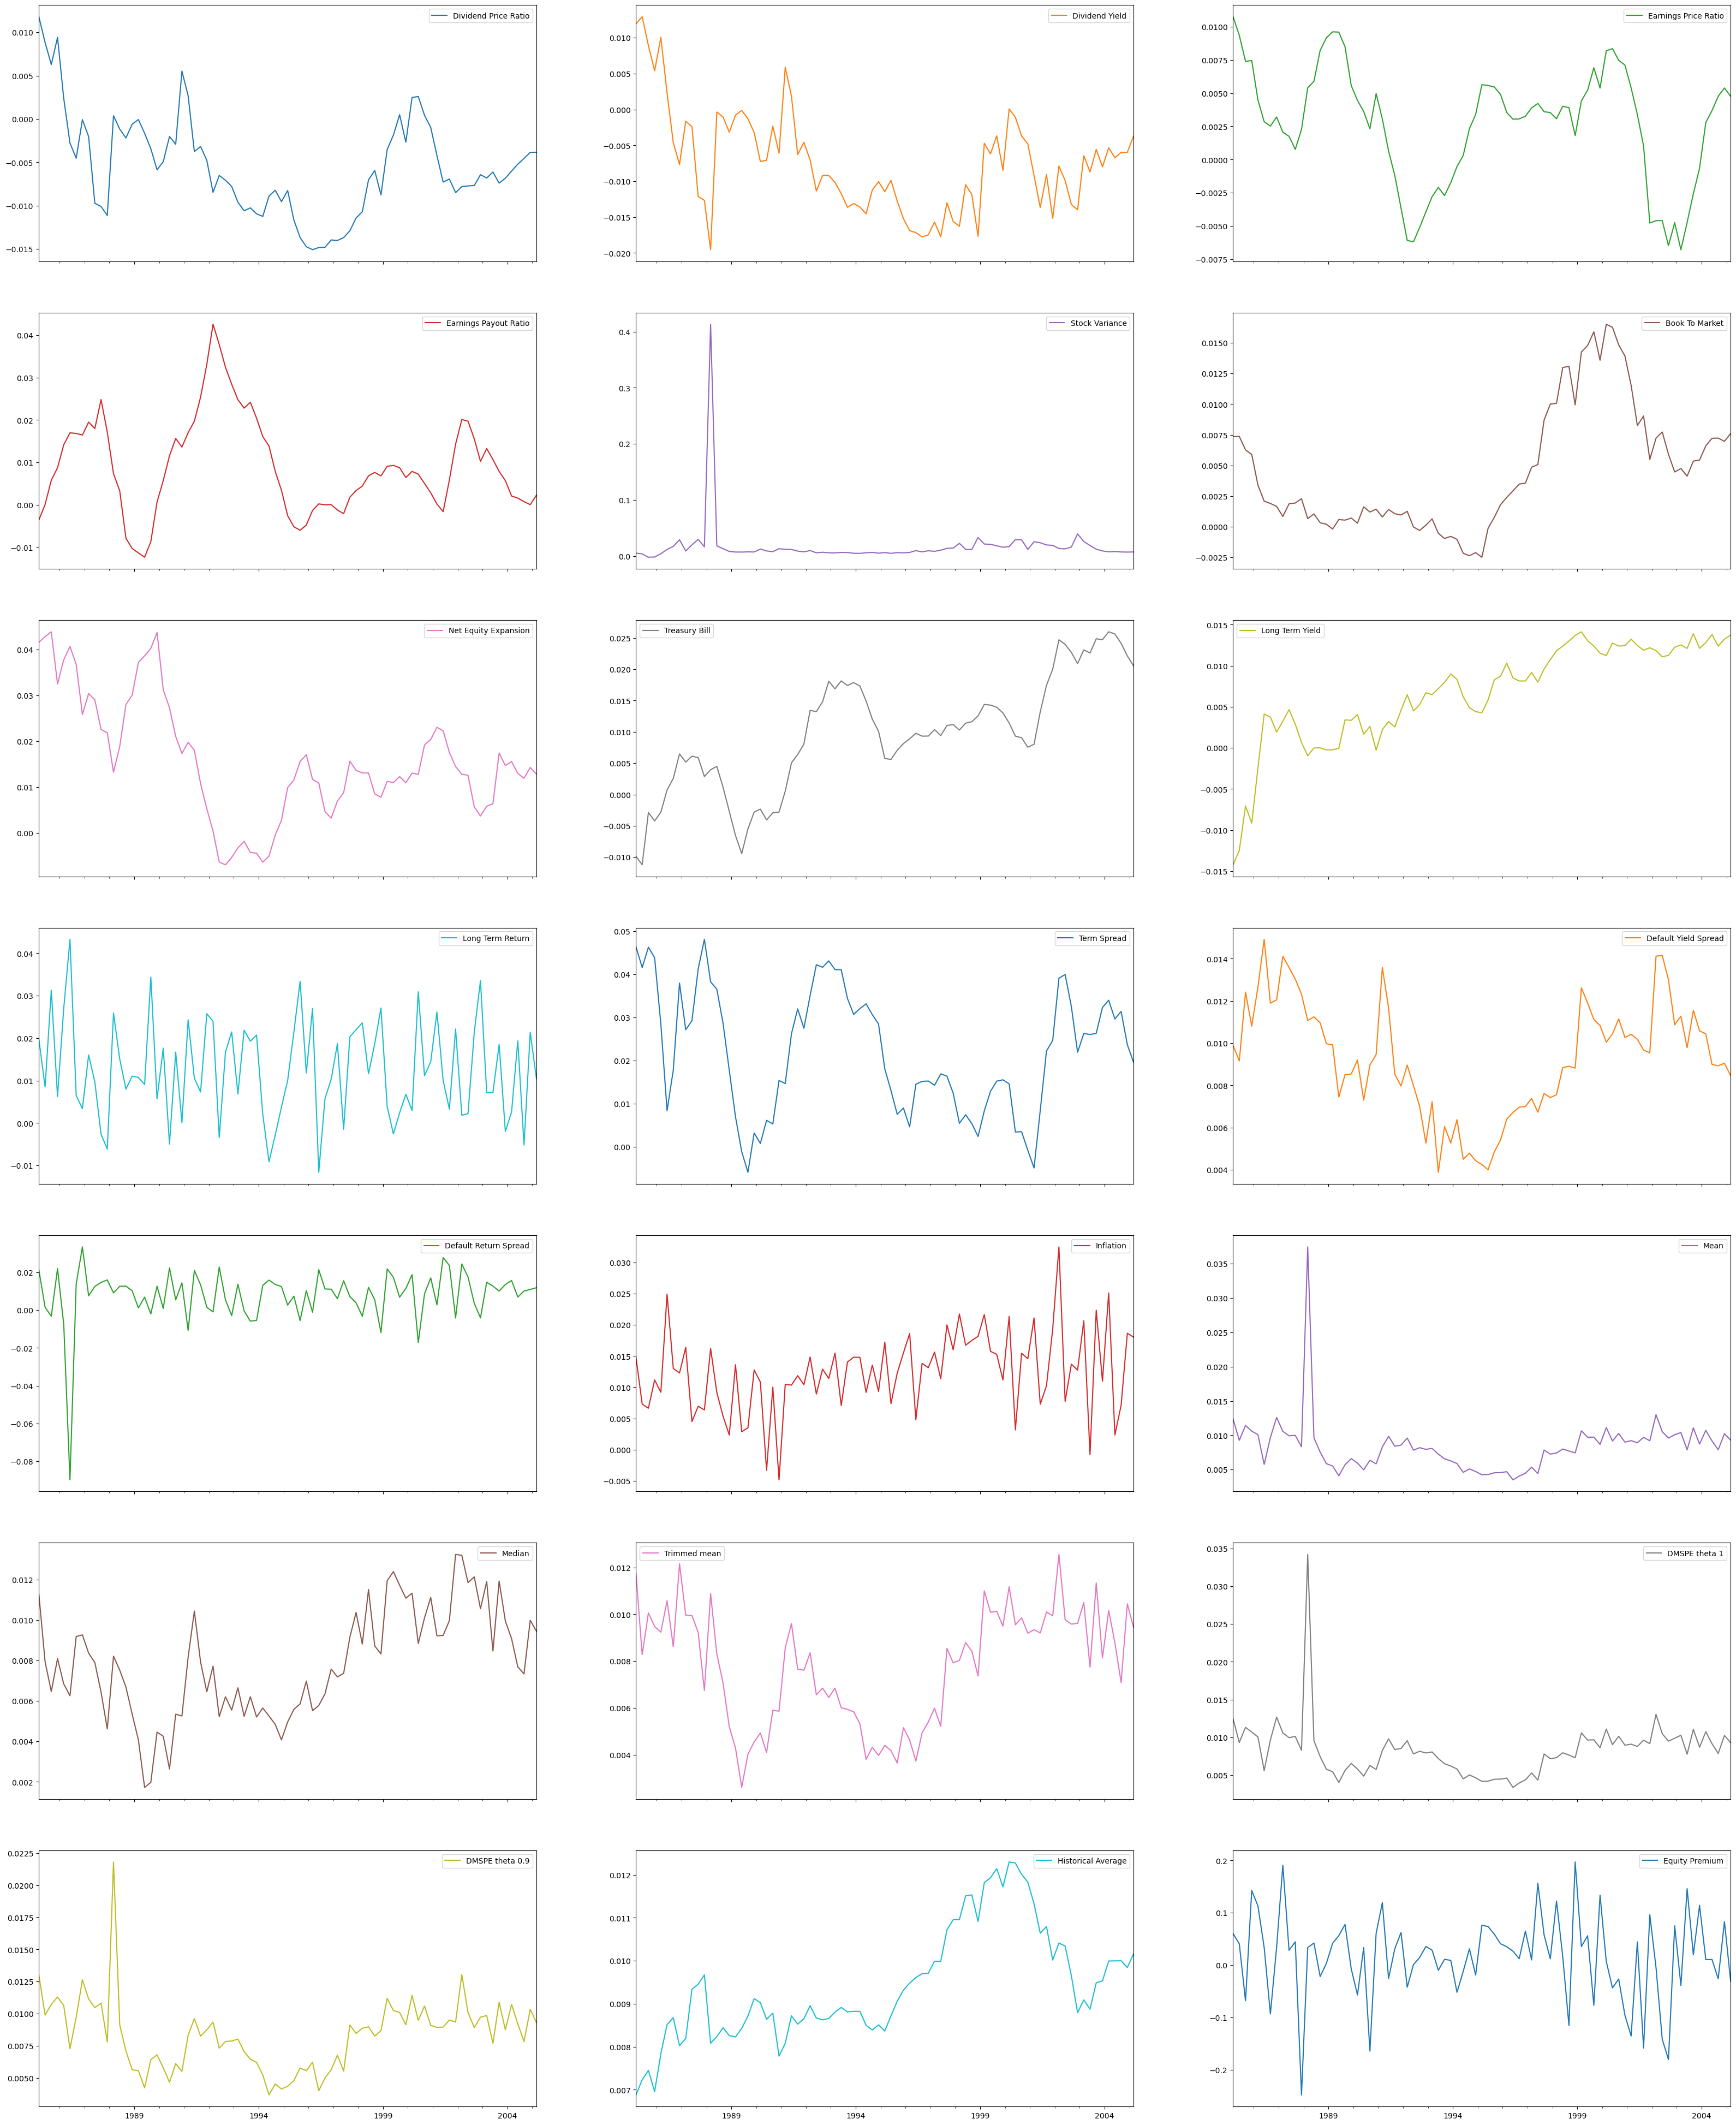

In [16]:

prediction_total.plot(subplots = True,
                        use_index = True,
                        fontsize = 10,
                        layout = (7,3), 
                        figsize = (40,50))

In [17]:
prediction_total.corr()

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,...,Default Yield Spread,Default Return Spread,Inflation,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9,Historical Average,Equity Premium
Dividend Price Ratio,1.000000,0.828771,0.460259,-0.053469,0.108409,0.248863,0.565757,-0.481345,-0.541721,0.067511,...,0.480016,-0.001763,-0.188330,0.376303,0.146700,0.422101,0.395897,0.433844,-0.236309,0.046178
Dividend Yield,0.828771,1.000000,0.407613,-0.041649,-0.226035,0.092788,0.665315,-0.500570,-0.571125,0.121484,...,0.464133,-0.119664,-0.162137,0.099049,0.034717,0.321612,0.128825,0.237966,-0.326632,0.018476
Earnings Price Ratio,0.460259,0.407613,1.000000,-0.751084,0.048981,0.265853,0.621721,-0.640299,-0.347565,0.024325,...,0.008983,0.002721,-0.163712,-0.031456,-0.186137,-0.114414,-0.040393,-0.018478,0.059764,0.099792
Earnings Payout Ratio,-0.053469,-0.041649,-0.751084,1.000000,-0.006562,-0.200398,-0.424201,0.276726,0.009277,-0.032629,...,0.162047,-0.060288,0.056437,0.178813,0.091382,0.252911,0.196777,0.201904,-0.123104,-0.136368
Stock Variance,0.108409,-0.226035,0.048981,-0.006562,1.000000,-0.005767,-0.026620,-0.029471,-0.063431,0.135860,...,0.149347,0.013079,0.084468,0.841004,0.098509,0.221398,0.806871,0.603022,-0.026717,0.018335
Book To Market,0.248863,0.092788,0.265853,-0.200398,-0.005767,1.000000,0.060588,0.236013,0.468557,0.010441,...,0.355830,0.081693,0.300445,0.200754,0.706962,0.582186,0.223246,0.417033,0.819418,-0.109985
Net Equity Expansion,0.565757,0.665315,0.621721,-0.424201,-0.026620,0.060588,1.000000,-0.709779,-0.543349,0.145714,...,0.486136,-0.121351,-0.167663,0.091124,-0.090723,0.155434,0.101874,0.187421,-0.250506,0.029965
Treasury Bill,-0.481345,-0.500570,-0.640299,0.276726,-0.029471,0.236013,-0.709779,1.000000,0.801003,-0.124251,...,-0.056181,0.125664,0.355890,0.083984,0.490123,0.286097,0.096577,0.126892,0.453012,-0.088260
Long Term Yield,-0.541721,-0.571125,-0.347565,0.009277,-0.063431,0.468557,-0.543349,0.801003,1.000000,-0.008397,...,-0.064775,0.005706,0.380862,-0.098173,0.441060,0.155763,-0.096146,-0.032266,0.793640,-0.101480
Long Term Return,0.067511,0.121484,0.024325,-0.032629,0.135860,0.010441,0.145714,-0.124251,-0.008397,1.000000,...,0.031337,-0.700744,0.202479,0.128776,0.002814,0.132071,0.121115,0.170746,-0.078139,0.131873


In [122]:
prediction_total.to_csv('../../data/linear_prediction_quarterly.csv')